<a href="https://colab.research.google.com/github/riotamoriya/kaggle/blob/main/tablar_nov_2021%5BEDA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Set the environment
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20


import sys
from pathlib import Path

if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')


from requests import get

name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
print(name_notebook)


from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_emwa/kaggle.json ~/.kaggle
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions list

tablar-nov-2021%5BEDA%5D.ipynb
Mounted at /content/drive
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=da9760187b36785a98b67f98661236570ae58d28f4866f5e15460c82d76cf637
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         77           False  
gan-getting-started                            2030-07-01 23:59:00  Getting 

In [2]:
tryproblem = 'tabular-playground-series-nov-2021'
tryproblem += '.zip'

!kaggle competitions download -c tabular-playground-series-nov-2021
import zipfile
with zipfile.ZipFile(tryproblem) as existing_zip:
    existing_zip.extractall('.')


 96% 409M/428M [00:03<00:00, 138MB/s]
100% 428M/428M [00:03<00:00, 132MB/s]


In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
print(f"Shape Train Dataset: {train.shape}")
print(f"Shape Test Dataset: {test.shape}")

train.head()

Shape Train Dataset: (600000, 102)
Shape Test Dataset: (540000, 101)


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,...,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209,0
3,3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float64(100), int64(2)
memory usage: 466.9 MB


In [12]:
print(f"Train Data Total Missing Values: {np.sum(train.isna().sum())}")
print(f"Test Data Total Missing Values: {np.sum(test.isna().sum())}")

Train Data Total Missing Values: 0
Test Data Total Missing Values: 0


Text(0, 1.05, '::Target Distribution')

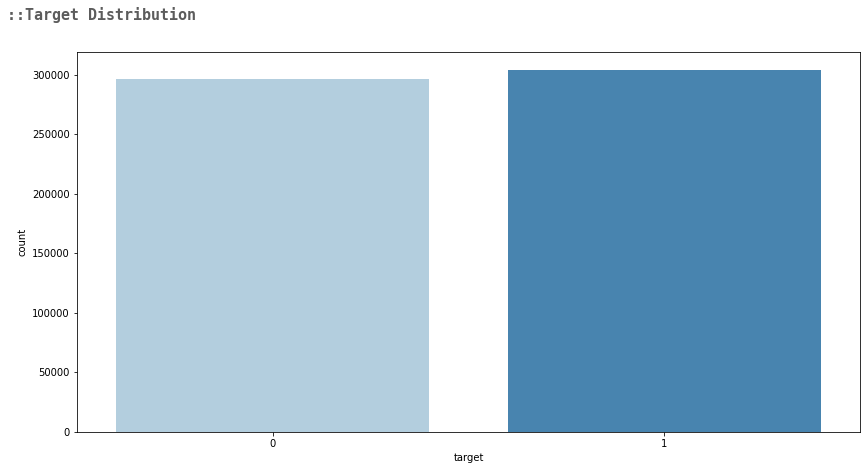

In [5]:
### create a countplot of target's distribution to check even split among classes

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(12,6))

sns.countplot(
    data=train,
    x='target',
    ax=ax,
    palette='Blues'
)

fig.text(
    s='::Target Distribution',
    x=0, y=1.05,
    color='#5c5c5c',
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

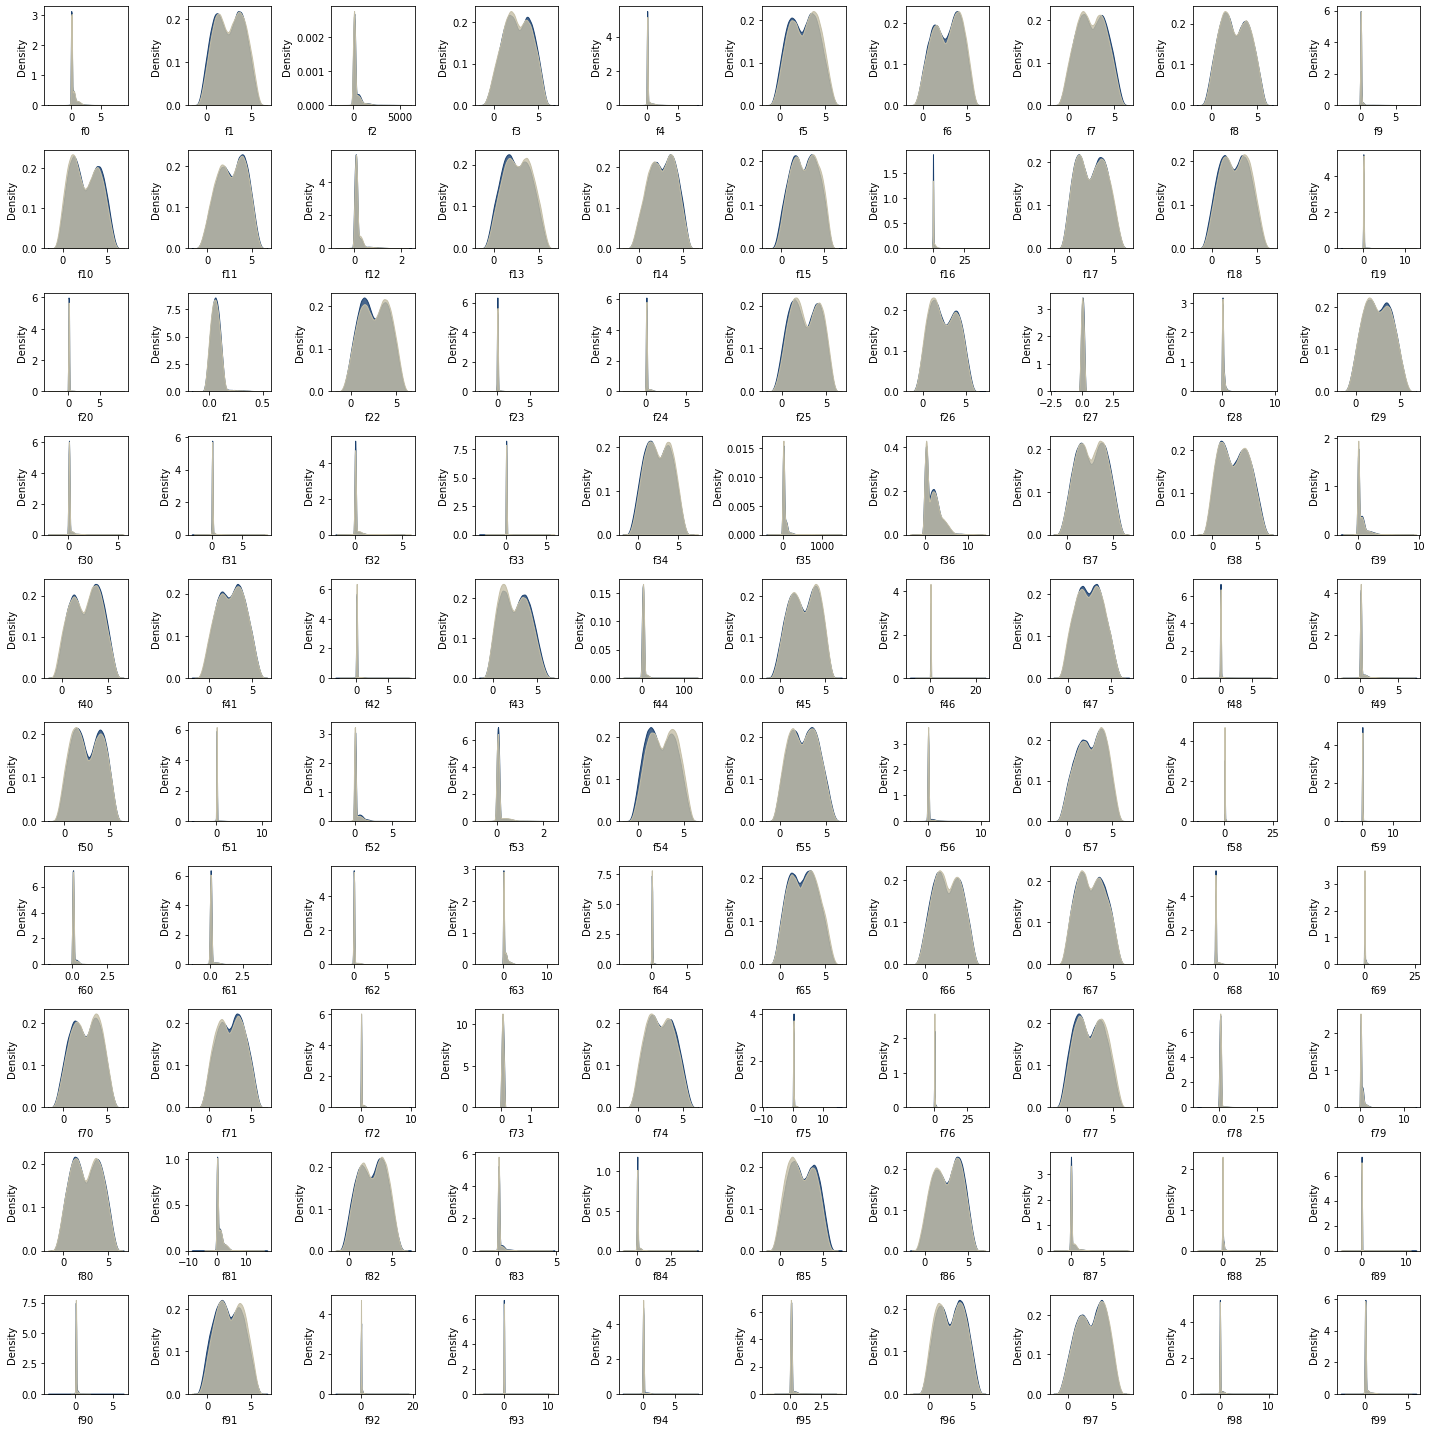

In [6]:
### create kdeplots for each feature, compare train vs. test distribution

# 特徴量のデータのみを切り出したい。特徴量はfから始まり、それ以外はfではないので、以下の条件を使っている。
feat_cols = [col for col in train.columns if col.startswith('f')] 

fig, ax = plt.subplots(10,  10, tight_layout=True, figsize=(20,20))
ax = ax.flatten()

for idx, feat in enumerate(feat_cols):
  # train
  sns.kdeplot(
      data=train,
      x=feat,
      ax=ax[idx],
      shade=True,
      alpha=0.8,
      color='#193f6e'
  )
  # test
  sns.kdeplot(
      data=test,
      x=feat,
      ax=ax[idx],
      shade=True,
      alpha=0.8,
      color='#c5bfa7'
  )

  ax[idx].set_yticks([])
  ax[idx].set_ylabel('')
  ax[idx].set_xlabel(xlabel=feat, fontweight='bold')

fig.text(
    s='::Feature Distribution || Train vs. Test',
    x=0, y=1.05,
    color='#5c5c5c', 
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

sns.despine()

# 10m47s

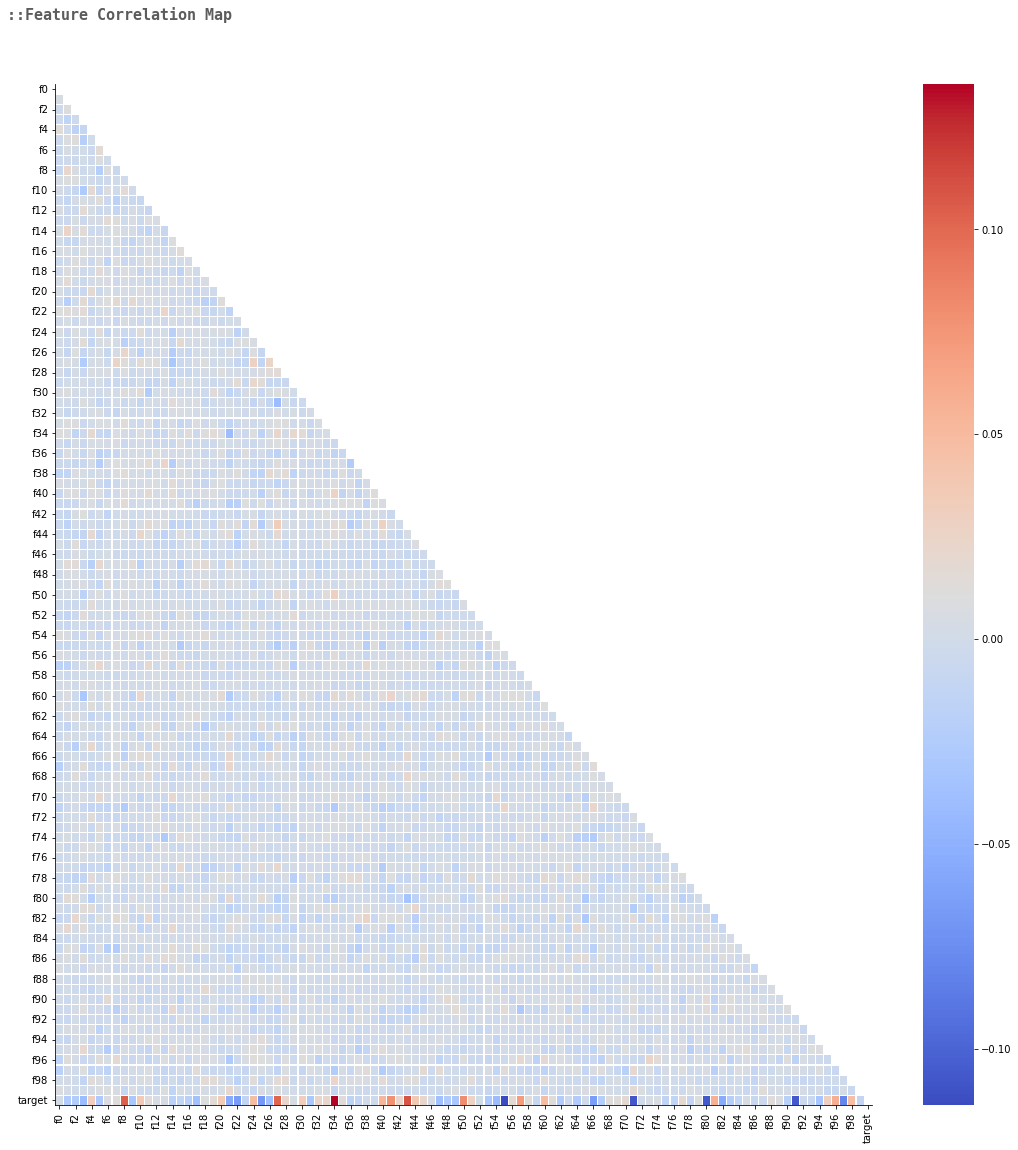

In [11]:
### create correlation map among all features

corr = train.drop(columns='id').corr()
mask = np.triu(corr)

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(15,15))

sns.heatmap(
    data=corr,
    cmap='coolwarm',
    annot=False,
    linewidth=0.05,
    cbar=True,
    mask=mask,
    ax=ax
)

fig.text(
    s='::Feature Correlation Map',
    x=0, y=1.05,
    color='#5c5c5c',
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

sns.despine()

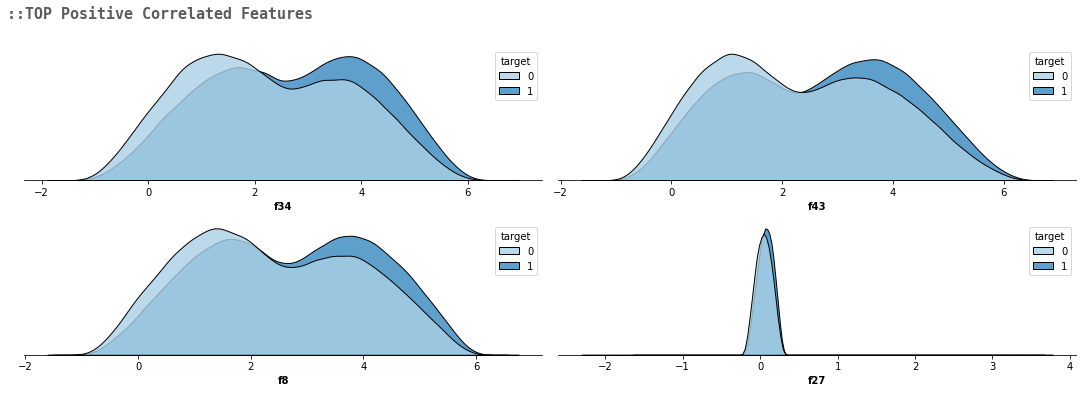

In [31]:
### create list with top correlating features and plot

# 相関係数が高い上位４つを取り出している。
pos_corr = corr['target'].sort_values(ascending=False)[1:5]

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(15, 5))
ax = ax.flatten()

for idx, feat in enumerate(pos_corr.index):
  sns.kdeplot(
      data=train,
      x=feat,
      hue='target',
      ax=ax[idx],
      palette='Blues',
      shade=True,
      alpha=0.8,
      edgecolor='black',
      linewidth=1
  )
  ax[idx].set_yticks([])
  ax[idx].set_ylabel('')
  ax[idx].set_xlabel(xlabel=feat, fontweight='bold')

fig.text(
    s='::TOP Positive Correlated Features',
    x=0, y=1.05,
    color='#5c5c5c',
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

sns.despine(left=True)

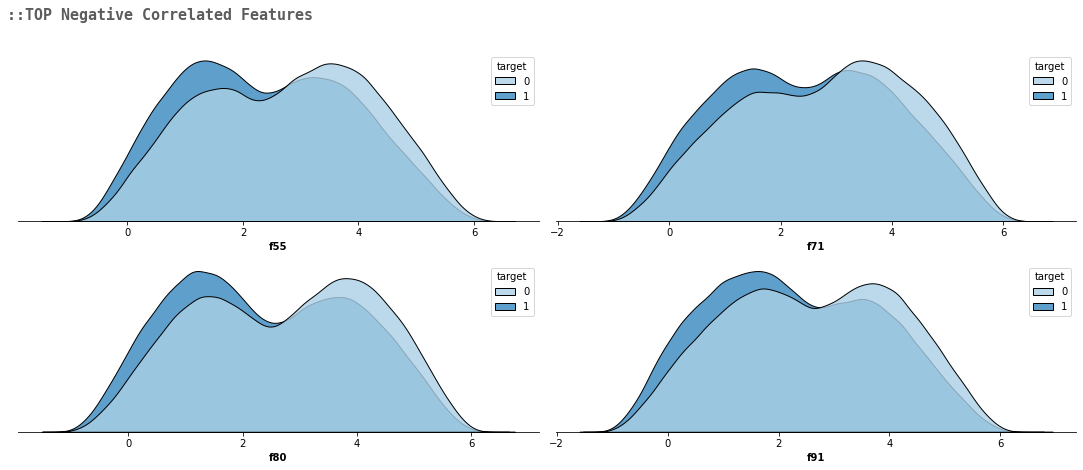

In [43]:
### create list with top correlating features and plot

# 相関係数が高い下位４つを取り出している。
neg_corr = corr['target'].sort_values(ascending=True)[:4]

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(15, 6))
ax = ax.flatten()

for idx, feat in enumerate(neg_corr.index):
  sns.kdeplot(
      data=train,
      x=feat,
      hue='target',
      ax=ax[idx],
      palette='Blues',
      shade=True,
      alpha=0.8,
      edgecolor='black',
      linewidth=1
  )
  ax[idx].set_yticks([])
  ax[idx].set_ylabel('')
  ax[idx].set_xlabel(xlabel=feat, fontweight='bold')

fig.text(
    s='::TOP Negative Correlated Features',
    x=0, y=1.05,
    color='#5c5c5c',
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

sns.despine(left=True)

In [34]:
### create row based features for further analysis
train['row_sum'] = train[feat_cols].sum(axis=1)
train['row_mean'] = train[feat_cols].mean(axis=1)
train['row_std'] = train[feat_cols].std(axis=1)

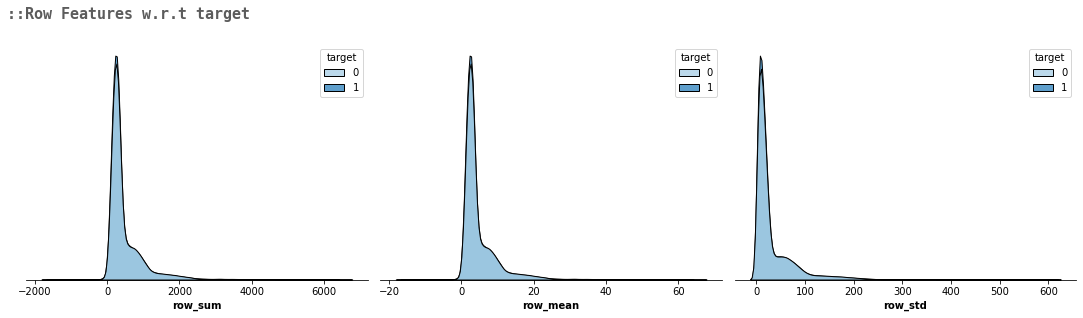

In [45]:
### get all row based features and plot distribution wrt to taget

row_feat = [col for col in train.columns if col.startswith('row')]

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(15,4))

for idx, feat in enumerate(row_feat):
  sns.kdeplot(
      data=train,
      x=feat,
      hue='target',
      ax=ax[idx],
      palette='Blues',
      shade=True,
      alpha=0.8,
      edgecolor='black',
      linewidth=1
  )
  ax[idx].set_yticks([])
  ax[idx].set_ylabel('')
  ax[idx].set_xlabel(xlabel=feat, fontweight='bold')

fig.text(
    s='::Row Features w.r.t target',
    x=0, y=1.05,
    color='#5c5c5c',
    fontfamily='monospace', fontsize=15, fontweight='bold'
)

sns.despine(left=True)